In [1]:
from fastai.vision.all import *
import torchvision
path=Path("/kaggle/input/lfw-yt")
files=get_image_files(path)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
class SiameseImage(fastuple):
    def show(self, ctx=None, **kwargs): 
        img1,img2,same_breed = self
        if not isinstance(img1, Tensor):
            if img2.size != img1.size: img2 = img2.resize(img1.size)
            t1,t2 = tensor(img1),tensor(img2)
            t1,t2 = t1.permute(2,0,1),t2.permute(2,0,1)
        else: t1,t2 = img1,img2
        line = t1.new_zeros(t1.shape[0], t1.shape[1], 10)
        return show_image(torch.cat([t1,line,t2], dim=2), 
                          title=same_breed, ctx=ctx)
class SiameseTransform(Transform):
    def __init__(self, files, label_func, splits):
        self.labels = files.map(label_func).unique()
        self.lbl2files = {l: L(get_image_files(path/l)) for l in self.labels}
        self.label_func = label_func
        self.valid = {f: self._draw(f) for f in files[splits[1]]}
        
    def encodes(self, f):
        f2,t = self.valid.get(f, self._draw(f))
        img1,img2 = PILImage.create(f),PILImage.create(f2)
        return SiameseImage(img1, img2, t)
    
    def _draw(self, f):
        same = random.random() < 0.5
        cls = self.label_func(f)
        if not same: cls = random.choice(L(l for l in self.labels if l != cls)) 
        return random.choice(self.lbl2files[cls]),same
    
splits = RandomSplitter()(files)
tfm = SiameseTransform(files, parent_label, splits)
tls = TfmdLists(files, tfm, splits=splits)

def halftone(img):
    if isinstance(img, PILImage):
        img1=img.convert("1").convert("L")
        return img1
    else:
        return img
    
def gray(img):
    if isinstance(img, PILImage):
        img1=img.convert("L")
        return img1
    else:
        return img
    
workers = min(8, num_cpus())
dls = tls.dataloaders(after_item=[Resize(224), ToTensor, gray], 
    after_batch=[IntToFloatTensor, Normalize.from_stats(*imagenet_stats)],
                     num_workers=workers)

#*aug_transforms()
class SiameseModel(Module):
    def __init__(self, encoder, head):
        self.encoder,self.head = encoder,head
    def forward(self, x1, x2):
        x1 = self.encoder(x1)
        x2 = self.encoder(x2)
        x1 = self.head(x1)
        x2 = self.head(x2)
        return x1, x2

In [3]:
@typedispatch
def show_batch(x:SiameseImage, y, samples, ctxs=None, max_n=6, nrows=None, ncols=2, figsize=None, **kwargs):
    if figsize is None: figsize = (ncols*6, max_n//ncols * 3)
    if ctxs is None: ctxs = get_grid(min(x[0].shape[0], max_n), nrows=None, ncols=ncols, figsize=figsize)
    for i,ctx in enumerate(ctxs): SiameseImage(x[0][i], x[1][i], ['Not similar','Similar'][x[2][i].item()]).show(ctx=ctx)

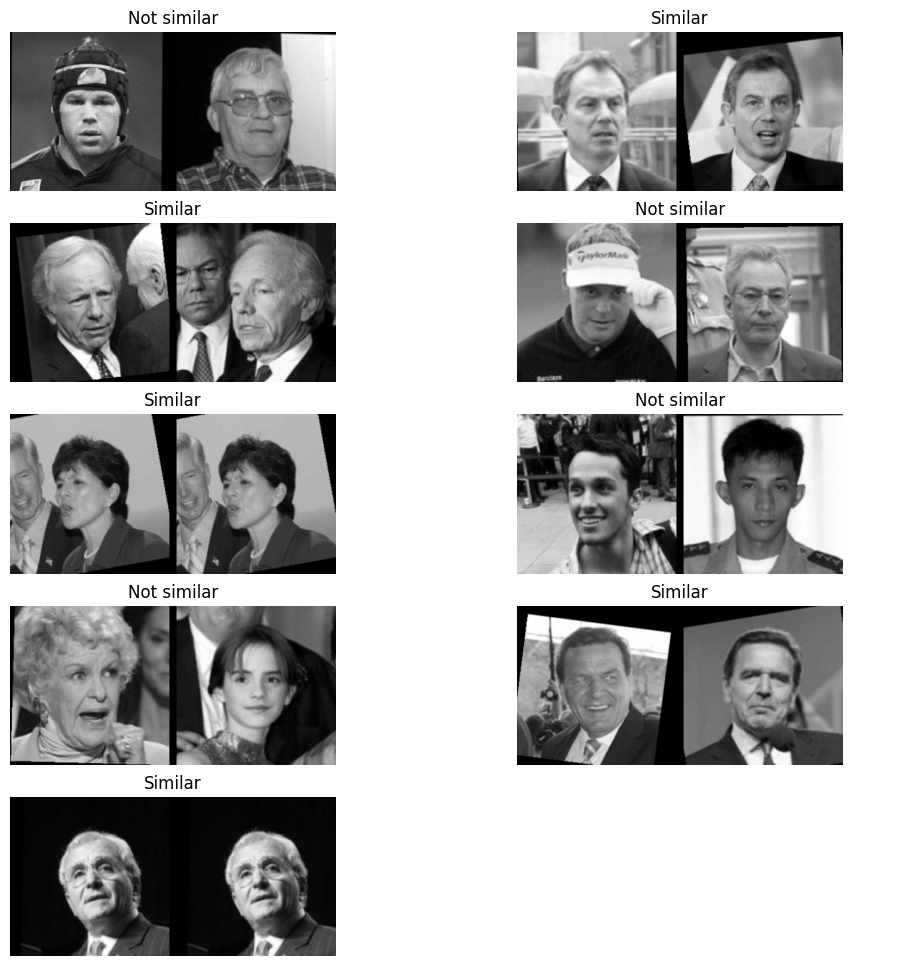

In [4]:
dls.show_batch()

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder = create_body(resnet50(weights=ResNet50_Weights.IMAGENET1K_V1), cut=-2)
head = create_head(512*4, 128, [512, 256], 0.5, bn_final=True)
model = SiameseModel(encoder, head)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 260MB/s]


In [6]:
from fastai.optimizer import Adam
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, ops, target, size_average=True):
        op1, op2 = ops[0], ops[1]
        dist = F.pairwise_distance(op1, op2)
        pdist = dist * target
        ndist = dist * (~target)
        loss = 0.5 * ((pdist**2) + (F.relu(self.margin - ndist)**2))
        loss = loss.mean() if size_average else loss.sum()
        return loss

def siamese_splitter(model):
    return [params(model.encoder), params(model.head)]
           

def contrastive_accuracy(ops, targets):
    op1, op2 = ops[0], ops[1]
    dists = F.pairwise_distance(op1, op2)
    optimal_threshold.find(dists, targets)
    preds = (dists < optimal_threshold.best_threshold).float()
    return (preds == targets).float().mean()

def accuracy(ops, targets):
    op1, op2 = ops[0], ops[1]
    dists = F.pairwise_distance(op1, op2)
    optimal_threshold.find(dists, targets)
    preds = (dists < optimal_threshold.best_threshold)

    true_positives = torch.sum((preds == 1) & (targets == 1)).item()
    true_negatives = torch.sum((preds == 0) & (targets == 0)).item()
    false_positives = torch.sum((preds == 1) & (targets == 0)).item()
    false_negatives = torch.sum((preds == 0) & (targets == 1)).item()

    accuracy = (true_positives + true_negatives) / (true_positives + true_negatives + false_positives + false_negatives) if (true_positives + true_negatives + false_positives + false_negatives) > 0 else 0.0

    return accuracy

def precision(ops, targets):
    op1, op2 = ops[0], ops[1]
    dists = F.pairwise_distance(op1, op2)
    optimal_threshold.find(dists, targets)
    preds = (dists < optimal_threshold.best_threshold)

    true_positives = torch.sum((preds == 1) & (targets == 1)).item()
    false_positives = torch.sum((preds == 1) & (targets == 0)).item()

    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0.0

    return precision

def recall(ops, targets):
    op1, op2 = ops[0], ops[1]
    dists = F.pairwise_distance(op1, op2)
    optimal_threshold.find(dists, targets)
    preds = (dists < optimal_threshold.best_threshold)

    true_positives = torch.sum((preds == 1) & (targets == 1)).item()
    false_negatives = torch.sum((preds == 0) & (targets == 1)).item()

    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0.0

    return recall

def f1_score(ops, targets):
    op1, op2 = ops[0], ops[1]
    dists = F.pairwise_distance(op1, op2)
    optimal_threshold.find(dists, targets)
    preds = (dists < optimal_threshold.best_threshold)

    true_positives = torch.sum((preds == 1) & (targets == 1)).item()
    false_positives = torch.sum((preds == 1) & (targets == 0)).item()
    false_negatives = torch.sum((preds == 0) & (targets == 1)).item()

    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0.0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0.0

    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0

    return f1_score

class OptimalThreshold:
    def __init__(self, start=0.1, end=4.0, step=0.01):
        self.start = start
        self.end = end
        self.step = step
        self.best_threshold = None

    def find(self, preds, targets):
        best_accuracy = 0.0
        for threshold in np.arange(self.start, self.end, self.step):
            preds_thresholded = (preds < threshold).float()
            accuracy = (preds_thresholded == targets).float().mean()
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                self.best_threshold = threshold
                
class PrintBestThreshold(Callback):
    def after_epoch(self):
        print(f"Epoch {self.learn.epoch} LR:{self.opt.hypers[0]['lr']:.10f} Best threshold: {optimal_threshold.best_threshold:.2f}")

optimal_threshold = OptimalThreshold()

learn = Learner(dls, model, loss_func=ContrastiveLoss(margin=2.5), opt_func=Adam,
                splitter=siamese_splitter, metrics=[accuracy, precision, recall, f1_score],cbs=PrintBestThreshold())

SuggestedLRs(valley=0.02754228748381138)

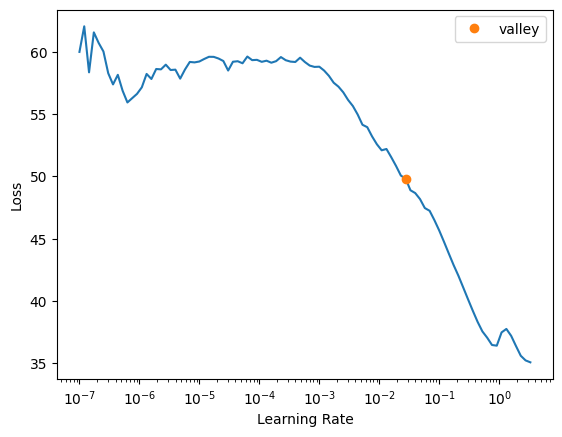

In [7]:
learn.lr_find()

In [8]:
learn.freeze()
learn.fit_one_cycle(10, 1e-2)

epoch,train_loss,valid_loss,accuracy,precision,recall,f1_score,time
0,9.980909,6.242026,0.832577,0.890464,0.757697,0.813617,01:32
1,4.267630,2.512503,0.843159,0.876307,0.805699,0.828359,01:32
2,2.192764,1.974631,0.858655,0.866424,0.856295,0.854152,01:32
3,1.959342,1.893378,0.882842,0.895730,0.867032,0.875390,01:32
4,1.917607,1.878332,0.889267,0.901630,0.875142,0.882465,01:32
5,1.913706,1.867506,0.891912,0.903839,0.882475,0.887883,01:32
6,1.879438,1.861962,0.895692,0.904327,0.889422,0.893782,01:32
7,1.900991,1.824393,0.918745,0.928972,0.904462,0.914678,01:33
8,1.887058,1.804275,0.925170,0.934329,0.914566,0.922175,01:32
9,1.847440,1.800811,0.929705,0.938314,0.918357,0.926631,01:32


Epoch 0 LR:0.0036819944 Best threshold: 1.89
Epoch 1 LR:0.0090616818 Best threshold: 2.35
Epoch 2 LR:0.0098933623 Best threshold: 1.10
Epoch 3 LR:0.0090525423 Best threshold: 1.09
Epoch 4 LR:0.0075110095 Best threshold: 0.74
Epoch 5 LR:0.0055353087 Best threshold: 0.88
Epoch 6 LR:0.0034670576 Best threshold: 0.57
Epoch 7 LR:0.0016638736 Best threshold: 0.76
Epoch 8 LR:0.0004375461 Best threshold: 0.59
Epoch 9 LR:0.0000001161 Best threshold: 0.62


In [9]:
learn.unfreeze()
learn.fit_one_cycle(20, slice(1e-5,1e-3))

epoch,train_loss,valid_loss,accuracy,precision,recall,f1_score,time
0,1.829198,1.796158,0.931595,0.939880,0.920563,0.928869,01:57
1,1.839092,1.791113,0.932729,0.936209,0.931810,0.931848,01:57
2,1.850692,1.790524,0.930839,0.938692,0.921389,0.926915,01:57
3,1.802667,1.782258,0.931217,0.936909,0.924709,0.928321,01:57
4,1.795566,1.781870,0.935752,0.937018,0.933022,0.933464,01:57
5,1.855693,1.765651,0.942555,0.944446,0.937867,0.939054,01:57
6,1.796711,1.766231,0.947846,0.947768,0.946654,0.945971,01:57
7,1.761311,1.761056,0.943311,0.943328,0.940877,0.940663,01:56
8,1.786430,1.758665,0.941421,0.936988,0.945093,0.939426,01:57
9,1.769469,1.748552,0.950113,0.951586,0.946136,0.947573,01:57


Epoch 0 LR:0.0000013060 Best threshold: 0.60
Epoch 1 LR:0.0000036993 Best threshold: 0.64
Epoch 2 LR:0.0000066659 Best threshold: 0.85
Epoch 3 LR:0.0000090725 Best threshold: 0.66
Epoch 4 LR:0.0000100000 Best threshold: 0.93
Epoch 5 LR:0.0000098921 Best threshold: 1.00
Epoch 6 LR:0.0000095703 Best threshold: 0.66
Epoch 7 LR:0.0000090488 Best threshold: 0.86
Epoch 8 LR:0.0000083504 Best threshold: 0.80
Epoch 9 LR:0.0000075055 Best threshold: 0.73
Epoch 10 LR:0.0000065512 Best threshold: 0.68
Epoch 11 LR:0.0000055290 Best threshold: 0.76
Epoch 12 LR:0.0000044837 Best threshold: 0.57
Epoch 13 LR:0.0000034610 Best threshold: 0.64
Epoch 14 LR:0.0000025056 Best threshold: 0.53
Epoch 15 LR:0.0000016591 Best threshold: 0.55
Epoch 16 LR:0.0000009587 Best threshold: 0.52
Epoch 17 LR:0.0000004350 Best threshold: 0.55
Epoch 18 LR:0.0000001107 Best threshold: 0.50
Epoch 19 LR:0.0000000001 Best threshold: 0.58


In [10]:
learn.export('resnet50_lfw_gray.pkl')
#learn = load_learner('resnet50_lfw_gray.pkl', cpu=False)